In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , accuracy_score
from IPython.display import clear_output


#if flatten is True means transform the image from a 28*28 Matrix(2D) to 784*1 Vector(1D)
#Flatten is necessary in logistic and softmax regression bec they are linear models in which z = W.X + B where X is 1 Dim vector
def load_mnist_data(flatten=False, batch_size=64):
    # Load datasets
    transform = transforms.ToTensor() #transform image from Numpy to pytorch tensor and make the values of each pixel between 0 and 1
    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, transform=transform, download=True
    )
    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, transform=transform, download=True
    )

    # float32 ensures numeric type, /255 normalizes pixels
    x_train = train_dataset.data.numpy().astype('float32') / 255.0
    y_train = train_dataset.targets.numpy()
    x_test  = test_dataset.data.numpy().astype('float32') / 255.0
    y_test  = test_dataset.targets.numpy()

    # Flatten for linear models
    if flatten:
        x_train = x_train.reshape(x_train.shape[0], -1) #reshape is the function used to covert the data from 28*28 matrix to 784*1 vector
        x_test  = x_test.reshape(x_test.shape[0], -1) #.shape is a fn that returns the dims #shape[0] return number of rows
    else:
        # Add channel dimension (for grayscale CNNs/NNs)
        x_train = x_train[:, None, :, :]
        x_test  = x_test[:, None, :, :]
        #None -> add new dim for the grayscale channel

    # test_size=0.25 → 75% train, 25% val (→ about 60/20/20 overall)
    x_train, x_val, y_train, y_val = train_test_split(
        x_train, y_train, test_size=0.25, stratify=y_train, random_state=42
    )

    # Convert numpy arrays to PyTorch tensors
    X_train_t = torch.tensor(x_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    X_val_t   = torch.tensor(x_val, dtype=torch.float32)
    y_val_t   = torch.tensor(y_val, dtype=torch.long)
    X_test_t  = torch.tensor(x_test, dtype=torch.float32)
    y_test_t  = torch.tensor(y_test, dtype=torch.long)

    # Create DataLoaders #dataloader is an object used in splitting data into batches and shuffle (reorder data randomly in each epoch) and used in itiration
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [ ]:
#binary logistic regression
def logistic_regression(train_loader, val_loader, test_loader, digit1=0, digit2=1, lr=0.01, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #checks if there are cuda cores (gpu) available to be used if not just use the cpu

    # Filter datasets for binary classification
    # choose only images with lablel 0 or 1 and in the lists x and y
    def filter_loader(loader):
        x_list, y_list = [], []
        for x, y in loader:
            mask = (y == digit1) | (y == digit2)
            x_list.append(x[mask])
            y_list.append((y[mask] == digit2).long())  # digit1=0, digit2=1
        return torch.cat(x_list), torch.cat(y_list)

    x_train, y_train = filter_loader(train_loader)
    x_val, y_val = filter_loader(val_loader)
    x_test, y_test = filter_loader(test_loader)

    # Flatten input if needed (e.g., for linear models)
    if len(x_train.shape) > 2:
        x_train = x_train.view(x_train.shape[0], -1)
        x_val = x_val.view(x_val.shape[0], -1)
        x_test = x_test.view(x_test.shape[0], -1)
    #logistic regression model definiton
    input_size = x_train.shape[1]
    w = torch.zeros((input_size, 1), requires_grad=True, device=device)
    b = torch.zeros(1, requires_grad=True, device=device)
    optimizer = torch.optim.SGD([w, b], lr=lr)  # Optional: Replace manual updates

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        # Training
        z = x_train.to(device) @ w + b #x_train.to(device) put the train data in the device (gpu/cpu)
        y_pred = torch.sigmoid(z).squeeze() #.squeeze() getrid of extra dims for example (N,1) -> (N,)
        loss = torch.nn.functional.binary_cross_entropy(y_pred, y_train.to(device).float()) #.float() to make sure that prediction is a float number
        loss.backward() #to calc gradients from back propagation
        optimizer.step()
        optimizer.zero_grad()

        pred_train = (y_pred > 0.5).long() # means if probability > 0,5 -> predict 1 else predict 0
        acc_train = (pred_train == y_train.to(device)).float().mean().item()
        # Validation
        with torch.no_grad():
            z_val = x_val.to(device) @ w + b
            y_val_pred = torch.sigmoid(z_val).squeeze()
            loss_val = torch.nn.functional.binary_cross_entropy(y_val_pred, y_val.to(device).float())
            acc_val = ((y_val_pred > 0.5).long() == y_val.to(device)).float().mean().item()

        train_losses.append(loss.item())
        val_losses.append(loss_val.item())
        train_accs.append(acc_train)
        val_accs.append(acc_val)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {loss.item():.4f}, Val Loss: {loss_val.item():.4f}, "
              f"Train Acc: {acc_train:.4f}, Val Acc: {acc_val:.4f}")

    # Test evaluation
    with torch.no_grad():
        z_test = x_test.to(device) @ w + b
        y_test_pred = torch.sigmoid(z_test).squeeze()
        preds_test = (y_test_pred > 0.5).long().cpu().numpy()
        acc_test = accuracy_score(y_test.numpy(), preds_test)
        cm = confusion_matrix(y_test.numpy(), preds_test)

    print(f"\nTest Accuracy: {acc_test:.4f}")
    print(f"Confusion Matrix (0={digit1}, 1={digit2}):\n{cm}")

    return train_losses, val_losses, train_accs, val_accs


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from IPython.display import clear_output

def logistic_regression_multiclass(train_loader, val_loader, test_loader, lr=0.01, epochs=10): #Softmax regression
    # Set device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Combine all batches into single tensors and ensure they're flattened
    def loader_to_tensor(loader):
        x_list, y_list = [], []
        for x, y in loader:
            x_list.append(x.view(x.size(0), -1))  # Force flattening
            y_list.append(y)
        return torch.cat(x_list), torch.cat(y_list)

    # Load and flatten data
    x_train, y_train = loader_to_tensor(train_loader)
    x_val, y_val = loader_to_tensor(val_loader)
    x_test, y_test = loader_to_tensor(test_loader)

    # Initialize parameters (Xavier initialization)
    input_size = x_train.shape[1]  # 784 for MNIST
    num_classes = 10               # Digits 0-9

    # Use nn.Parameter for weights and biases
    W = nn.Parameter(torch.randn((input_size, num_classes), device=device) * 0.01)
    b = nn.Parameter(torch.zeros(num_classes, device=device))
    #why not just initailize w and b with zeros ?
    #because here we have 10 labels so if we started with w=0 and b=0 then softmax will give all classes 1/10 prediction and the gradients will be identical so the model won't be able to distinguish between numbers


    # Use an optimizer
    optimizer = torch.optim.SGD([W, b], lr=lr) #update the weights using the gradients calculated from back propagation

    # Training tracking
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        # ---- Training ----
        Z = x_train.to(device) @ W + b
        loss = F.cross_entropy(Z, y_train.to(device))  # More stable than manual

        # Backpropagation
        loss.backward()
        optimizer.step() # Use optimizer to update weights and biases
        optimizer.zero_grad() # Clear gradients

        # Calculate accuracy
        preds_train = Z.argmax(dim=1)
        acc_train = (preds_train == y_train.to(device)).float().mean().item()

        # ---- Validation ----
        with torch.no_grad():
            Z_val = x_val.to(device) @ W + b
            loss_val = F.cross_entropy(Z_val, y_val.to(device))
            preds_val = Z_val.argmax(dim=1)
            acc_val = (preds_val == y_val.to(device)).float().mean().item()

        # Store metrics
        train_losses.append(loss.item())
        val_losses.append(loss_val.item())
        train_accs.append(acc_train)
        val_accs.append(acc_val)

        # Dynamic plotting
        clear_output(wait=True)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.legend()
        plt.title('Loss Curves')

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.legend()
        plt.title('Accuracy Curves')
        plt.show()

        print(f'Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {loss.item():.4f}, Val Loss: {loss_val.item():.4f}, '
              f'Train Acc: {acc_train:.4f}, Val Acc: {acc_val:.4f}')

    # ---- Final Test Evaluation ----
    with torch.no_grad():
        Z_test = x_test.to(device) @ W + b
        preds_test = Z_test.argmax(dim=1).cpu().numpy()

    acc_test = accuracy_score(y_test.numpy(), preds_test)
    cm = confusion_matrix(y_test.numpy(), preds_test)

    print(f'\nFinal Test Accuracy: {acc_test:.4f}')
    print('Confusion Matrix:')
    print(cm)

    return {
        'weights': W.cpu().detach(),
        'biases': b.cpu().detach(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'test_accuracy': acc_test
    }

In [ ]:
# Load the MNIST data for binary classification (flatten=True for logistic regression)
train_loader_binary, val_loader_binary, test_loader_binary = load_mnist_data(flatten=True)

# Train the binary logistic regression model for digits 0 and 1
logistic_regression(train_loader_binary, val_loader_binary, test_loader_binary, digit1=0, digit2=1, epochs=5)

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.85MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.28MB/s]


Epoch 1/5: Train Loss: 0.6931, Val Loss: 0.6611, Train Acc: 0.4677, Val Acc: 0.9867
Epoch 2/5: Train Loss: 0.6609, Val Loss: 0.6320, Train Acc: 0.9915, Val Acc: 0.9886
Epoch 3/5: Train Loss: 0.6317, Val Loss: 0.6053, Train Acc: 0.9922, Val Acc: 0.9889
Epoch 4/5: Train Loss: 0.6050, Val Loss: 0.5809, Train Acc: 0.9929, Val Acc: 0.9902
Epoch 5/5: Train Loss: 0.5805, Val Loss: 0.5584, Train Acc: 0.9933, Val Acc: 0.9915

Test Accuracy: 0.9972
Confusion Matrix (0=0, 1=1):
[[ 980    0]
 [   6 1129]]


([0.6931474208831787,
  0.6609430313110352,
  0.6316787004470825,
  0.604963481426239,
  0.5804640650749207],
 [0.6610990762710571,
  0.631960928440094,
  0.6053476929664612,
  0.5809305906295776,
  0.5584318041801453],
 [0.46767741441726685,
  0.9914718866348267,
  0.9922088980674744,
  0.9929459095001221,
  0.9932617545127869],
 [0.9867382645606995,
  0.9886327981948853,
  0.9889485239982605,
  0.990211546421051,
  0.9914745688438416])

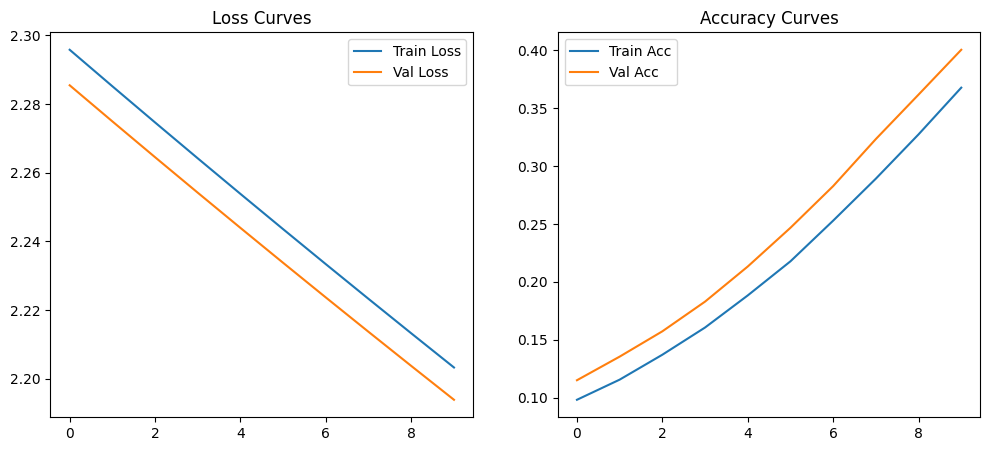

Epoch 10/10: Train Loss: 2.2033, Val Loss: 2.1939, Train Acc: 0.3679, Val Acc: 0.4006

Final Test Accuracy: 0.4172
Confusion Matrix:
[[510   0   9   9   1   3  26   8 393  21]
 [  0 432  11 166   0   0   9 163 281  73]
 [ 62   3 427 244   2   0  23  18 212  41]
 [ 16   3  14 669   3   0  25   9 221  50]
 [ 21   3  44  12  83   0  57 184 348 230]
 [ 51  22   6 112  10   7  59  16 564  45]
 [ 60   1  69  24  10   0 517  57 174  46]
 [ 97   3  18  14   1   2   8 517 158 210]
 [  7   4  15 188   3   0  20  52 669  16]
 [ 37   2  17  18  50   0  12 131 401 341]]


{'weights': tensor([[-2.4276e-03, -4.1479e-03, -4.1739e-03,  ...,  9.6436e-03,
          -1.1116e-02, -4.5854e-05],
         [-1.5599e-03, -7.6024e-03,  2.2506e-04,  ..., -4.0349e-03,
          -1.2276e-02,  1.4845e-03],
         [-5.7593e-03,  8.3940e-03,  1.5536e-02,  ...,  1.1126e-02,
          -8.8229e-03,  1.0316e-02],
         ...,
         [-1.0321e-02, -1.1079e-02,  1.4528e-02,  ...,  1.1217e-02,
          -3.7752e-03, -1.3558e-02],
         [-5.5189e-03,  4.2964e-04,  3.1259e-03,  ...,  4.3180e-03,
           1.4979e-02,  1.2968e-02],
         [ 9.1662e-04,  8.4727e-03,  8.9965e-03,  ...,  1.8319e-03,
          -5.3804e-04,  4.8047e-03]]),
 'biases': tensor([ 5.7556e-05,  2.1620e-03,  3.8137e-05, -1.3731e-04,  2.4218e-05,
          2.4108e-04, -4.4121e-04,  2.3878e-05, -1.3985e-03, -5.6979e-04]),
 'train_losses': [2.29579758644104,
  2.2851693630218506,
  2.2746331691741943,
  2.2641873359680176,
  2.253829002380371,
  2.2435572147369385,
  2.2333695888519287,
  2.223265171051

In [ ]:
# Load the MNIST data for multiclass classification (flatten=True for logistic regression)
train_loader_multiclass, val_loader_multiclass, test_loader_multiclass = load_mnist_data(flatten=True)

# Train the multiclass logistic regression model
logistic_regression_multiclass(train_loader_multiclass, val_loader_multiclass, test_loader_multiclass, epochs=10)